In [29]:
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.stats import median_abs_deviation as mad

In [26]:
def mad_outlier(adata, metric, nmads):
    M = adata.obs[metric]
    return (M < np.median(M) - nmads * mad(M)) | (M > np.median(M) + nmads * mad(M))
    

def pp(sample_id):
    adata = sc.read_10x_mtx(sample_id + '/outs/filtered_feature_bc_matrix')
    adata.obs['sample_id'] = sample_id
    
    
    #calculate QC metrics
    adata.var["mt"] = adata.var_names.str.startswith("mt-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"],
                               inplace=True, percent_top=[20], log1p=True)
    
    
    #filter outliers
    bool_vector = mad_outlier(adata, 'log1p_total_counts', 5) +\
        mad_outlier(adata, 'log1p_n_genes_by_counts', 5) +\
        mad_outlier(adata, 'pct_counts_in_top_20_genes', 5) +\
        mad_outlier(adata, 'pct_counts_mt', 3)
    
    adata = adata[~bool_vector]
    
    return adata
    

In [30]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [36]:
def get_soupx_group(adata):
    adata_pp = adata.copy()
    sc.pp.normalize_per_cell(adata_pp)
    sc.pp.log1p(adata_pp)
    sc.pp.pca(adata_pp)
    sc.pp.neighbors(adata_pp)
    sc.tl.leiden(adata_pp, key_added="soupx_groups")
    return adata_pp.obs['soupx_groups']
    
    

def prepare_broth(adata):
    # Make into individual components to pass to R
    cells = adata.obs_names
    genes = adata.var_names
    data = adata.X.T
    
    #get raw data
    sample_id = adata.obs.iloc[0]['sample_id']
    raw = sc.read_10x_mtx(sample_id + '/outs/raw_feature_bc_matrix/').X.T
    
    #get leiden clusters
    soupx_groups = get_soupx_group(adata)

    return data, raw, genes, cells, soupx_groups
    

In [42]:
%%R

library(SoupX)

make_soup <- function(data, raw, genes, cells, soupx_groups){
    # specify row and column names of data
    rownames(data) = genes
    colnames(data) = cells
    # ensure correct sparse format for table of counts and table of droplets
    data <- as(data, "sparseMatrix")
    raw <- as(raw, "sparseMatrix")

    # Generate SoupChannel Object for SoupX 
    sc = SoupChannel(raw, data, calcSoupProfile = FALSE)

    # Add extra meta data to the SoupChannel object
    soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
    sc = setSoupProfile(sc, soupProf)
    # Set cluster information in SoupChannel
    sc = setClusters(sc, soupx_groups)

    # Estimate contamination fraction
    sc  = autoEstCont(sc, doPlot=FALSE)
    # Infer corrected table of counts and round to integer
    out = adjustCounts(sc, roundToInt = TRUE)
    
    return(out)
}



    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [43]:
def cook_soup(adata):
    data, raw, genes, cells, soupx_groups = prepare_broth(adata)

    # Execute the R code and get the corrected counts
    %R -i data -i raw -i genes -i cells -i soupx_groups -o out out = make_soup(data, raw, genes, cells, soupx_groups)


    adata.layers["raw_counts"] = adata.X
    adata.layers["soupX_counts"] = out.T
    adata.X = adata.layers["soupX_counts"]
    
    return adata




In [6]:
sample_ids = ['Lung1', 'Lung2', 'Lung3', 'Lung4', 'Lung6']

In [79]:
adatas = [pp(adata) for adata in sample_ids]

In [80]:
adatas = [cook_soup(adata) for adata in adatas]

In [ ]:
adatas[0].layers['soupX_counts'].sum()/adatas[0].layers['raw_counts'].sum()

# Simple normalization and integration just for visualizaiton

In [74]:
import scanorama
from matplotlib.pyplot import rc_context

In [85]:
def norm_for_integration(adata):
    sc.pp.filter_genes(adata, min_cells = 1, inplace = True)
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=4000, inplace=True, subset = True)
    return adata

In [86]:
norm_adatas = [norm_for_integration(adata.copy()) for adata in adatas]

scanorama.integrate_scanpy(norm_adatas)
scanorama_int = [adata.obsm['X_scanorama'] for adata in norm_adatas] #extracting from integrated objects

Found 1284 genes among all datasets
[[0.         0.80743355 0.62447844 0.22381566 0.25482234]
 [0.         0.         0.58310356 0.47292942 0.36446701]
 [0.         0.         0.         0.25636481 0.65279188]
 [0.         0.         0.         0.         0.59168547]
 [0.         0.         0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (2, 4)
Processing datasets (0, 2)
Processing datasets (3, 4)
Processing datasets (1, 2)
Processing datasets (1, 3)
Processing datasets (1, 4)
Processing datasets (2, 3)
Processing datasets (0, 4)
Processing datasets (0, 3)


In [87]:
adata = sc.concat(adatas, index_unique='_')
adata.obsm["X_scanorama"] = np.concatenate(scanorama_int) #adding scanormama embeddings on to raw data

sc.pp.neighbors(adata, use_rep = "X_scanorama")
sc.tl.umap(adata)

In [110]:
before = adata.layers['raw_counts'].copy()
after = adata.layers['soupX_counts'].copy()

before.data = np.where(before.data > 0, 1, 0) #binarized before soupX
after.data = np.where(after.data > 0, 1, 0) #binarized soupX

diff = before - after #if went from 1 to 0 the diff will be 1, all other 0 or -1

changed = (diff == 1).astype(int) #binary matrix, will be 1 if was taken out, otherwise 0

In [112]:
adata.layers['changed'] = changed

In [145]:
adata.var['soupX_removed'] = adata.layers['changed'].sum(axis = 0).A1 #num cells gene was subtracted from

In [148]:
adata.var.sort_values('soupX_removed', ascending = False)

,soupX_removed
Cd74,11151
Lyz2,10540
Apoe,8942
Mgp,8561
Chil3,7378
...,...
Gm33619,0
Gm40608,0
Gm26577,0
Gm48189,0


In [116]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

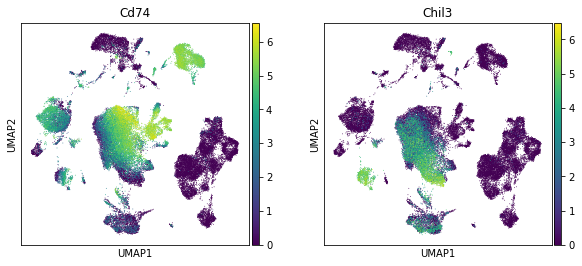

In [175]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color = ['Cd74', 'Chil3'])

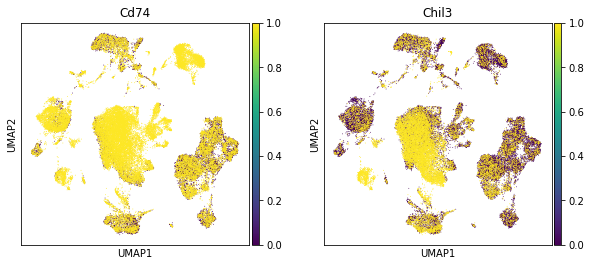

In [174]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color = ['Cd74', 'Chil3'], vmax = 1, layer = 'raw_counts')

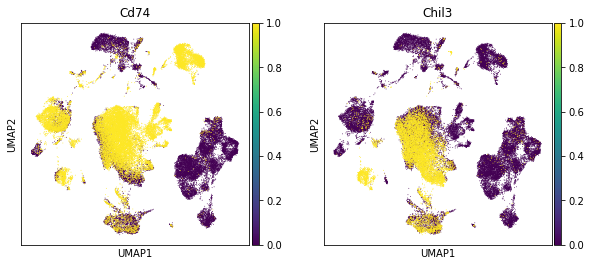

In [173]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color = ['Cd74', 'Chil3'], vmax = 1, layer = 'soupX_counts')

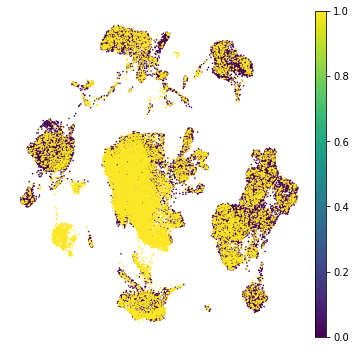

In [193]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata, color = ['Chil3'], vmax = 1, layer = 'raw_counts', s = 10, frameon = False, title = '')

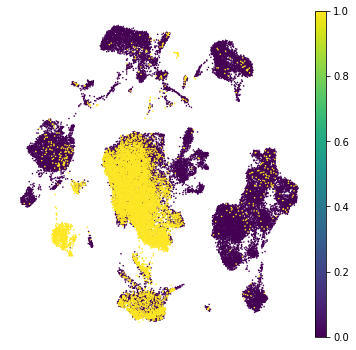

In [194]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata, color = ['Chil3'], vmax = 1, layer = 'soupX_counts', s = 10, frameon = False, title = '')